In [1]:
import data_process as process
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
import warnings
warnings.filterwarnings('ignore')

# 1. Data Prepocessing

In [3]:
### Load the bids and payloads CSV files ###

origin_bids_df = pd.read_csv("data/Eden_MEV-Boost_bid_20240404.csv") # MEV-Boost bids data from Eden Public Data
origin_payload_df = pd.read_csv("data/mev_blocks_19580000_to_19589999.csv") # MEV-Boost Winning Bid Data

# Check if matched_df already exists in the current namespace
if 'matched_df' not in locals():
    # Process the data if matched_df does not exist
    bids_df, payload_df = process.cleaning(origin_bids_df, origin_payload_df) # using the data_process.py
    bids_df, payload_df = process.transformation(bids_df, payload_df)
    matched_df, origin_matched_df = process.get_matched_df(bids_df, payload_df)
    
else:
    print("matched_df already exists. Skipping processing steps.")

Data cleaning has completed
Data transformation has completed
Amount of distinct block_number in bids_df: 1206
Amount of matched block_number in payload_df:  1036
Amount of distinct winner block_hash: 1036
Got matched_df (winner bids data)


# 2. Build Random Forest Regression Model

In [4]:
# parameter sets
parameters1 = ['base_fee_per_gas','normalised_num_tx','normalised_value','gasUsedRatio', 'bids_count', 'normalised_t_diff'] # predictors
parameters2 = ['base_fee_per_gas','normalised_num_tx','normalised_value','gasUsedRatio', 'bids_count', 'time_difference_max']

### Choose dataset based on 'slot' ###

def dataset (slot, slot_range = 600, responser = 'time_difference_max', parameters = parameters1, df = matched_df):
    slot_range = range(slot - slot_range, slot)
    X = df[df['slot'].isin(slot_range)][parameters]
    y = df[df['slot'].isin(slot_range)][responser]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
    return X_train, X_test, y_train, y_test

In [5]:
### Build Random Forest Regression Model ###

# RF model (for all matched_df)
def RF_all(responser, parameters, colour, n_estimators=100, test_size=0.2, random_state=42):
    
    X = matched_df[parameters]
    y = matched_df[responser] 
    
    # Partition the data for training and testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Initialize the Random Forest Regressor
    rf_regressor = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state)

    # Train the model
    rf_regressor.fit(X_train, y_train)

    # Make predictions
    y_pred = rf_regressor.predict(X_test)

    # Evaluate the model
    error_score = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print(f"【{responser}】")
    print(f"\nR squared error (ALL matched): {error_score}")
    print(f"Mean Squared Error (ALL matched): {mse}")
    print(f"Root Mean Squared Error (ALL matched): {rmse}")
    print("Number of training data:", len(y_train))
    print("Number of testing data:", len(y_test))

    plt.plot(list(y_test), color='red', label='Actual ' + responser)
    plt.plot(y_pred, color=colour, label='Predicted ' + responser)
    plt.title('Actual ' + responser + ' vs Predicted ' + responser)
    plt.xlabel('Values Count')
    plt.ylabel(responser + ' (s)')
    plt.legend()

    # Save the plot
    plt.savefig(f'graphs/ALL_matched {responser} - Random Forest Regression Model.png')
    plt.show()

In [6]:
# RF model (select slot range)
def RF (slot, slot_range, responser, parameters, colour):
    X_train, X_test, y_train, y_test = dataset (slot, slot_range, responser, parameters)
    
    rf_regressor = RandomForestRegressor(n_estimators=30)

    rf_regressor.fit(X_train,y_train)

    y_pred = rf_regressor.predict(X_test)

    # R squared error
    error_score = r2_score(y_test, y_pred)
    print(f"\nR squared error ({responser}, slot range = {slot_range}): ", error_score)

    print("Number of training data:", len(y_train))
    print("Number of testing data:", len(y_test))

    # plot
    plt.figure(figsize=(10, 8))
    plt.plot(list(y_test), color='red', label = 'Actual ' + responser)
    plt.plot(y_pred, color=colour, label='Predicted ' + responser)
    plt.title('Actual ' + responser + ' vs Predicted ' + responser)
    plt.xlabel('Values Count')
    plt.ylabel(responser + ' (s)')
    plt.legend()

    plt.savefig(f'graphs/{responser}_{slot_range} - Random Forest Regression Model.png')
    plt.show()

### Plot the Model Prediction of different target variables

【time_difference_max】

R squared error (ALL matched): 0.44206306644895044
Mean Squared Error (ALL matched): 0.1506993413497235
Root Mean Squared Error (ALL matched): 0.3882001305380042
Number of training data: 722
Number of testing data: 181


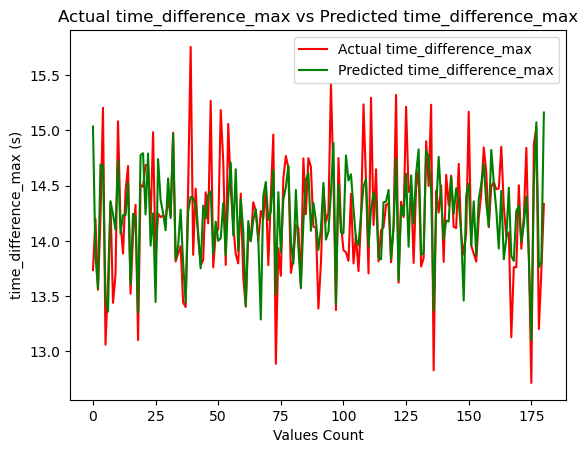

In [7]:
RF_all('time_difference_max', parameters1, 'green')

【time_difference】

R squared error (ALL matched): 0.2960101295662141
Mean Squared Error (ALL matched): 0.17019412637016693
Root Mean Squared Error (ALL matched): 0.4125459081970962
Number of training data: 722
Number of testing data: 181


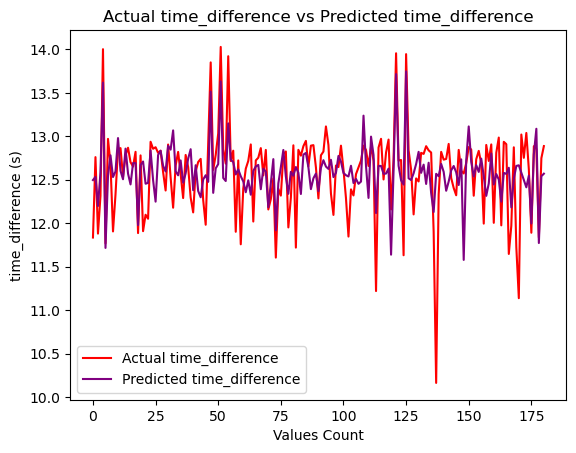

In [8]:
RF_all('time_difference', parameters2, 'purple')

【normalized_t_diff】

R squared error (ALL matched): 0.34575449314085316
Mean Squared Error (ALL matched): 0.0006373363992256467
Root Mean Squared Error (ALL matched): 0.025245522359928437
Number of training data: 722
Number of testing data: 181


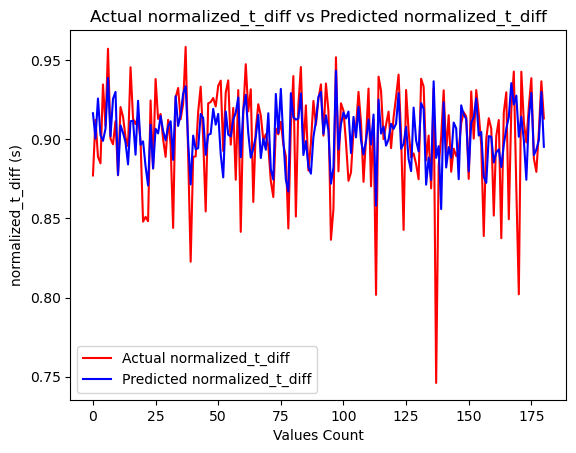

In [9]:
RF_all('normalised_t_diff', parameters2, 'blue')

### Change Scale (slot range)


R squared error (time_difference_max, slot range = 600):  0.21498247465494513
Number of training data: 334
Number of testing data: 84


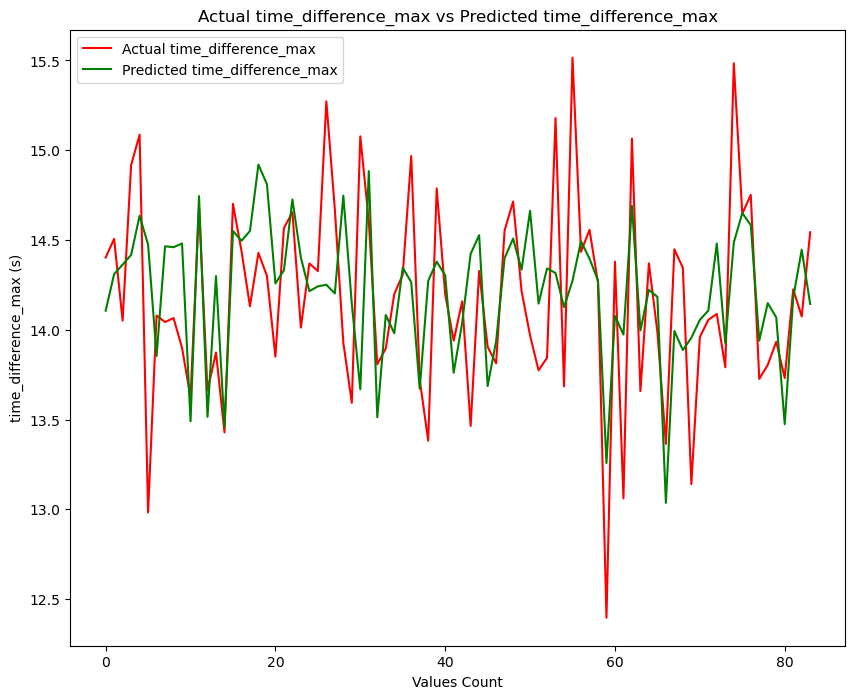

In [10]:
RF(8787590, 600, 'time_difference_max', parameters1, 'green')


R squared error (time_difference, slot range = 600):  0.4087590061536973
Number of training data: 334
Number of testing data: 84


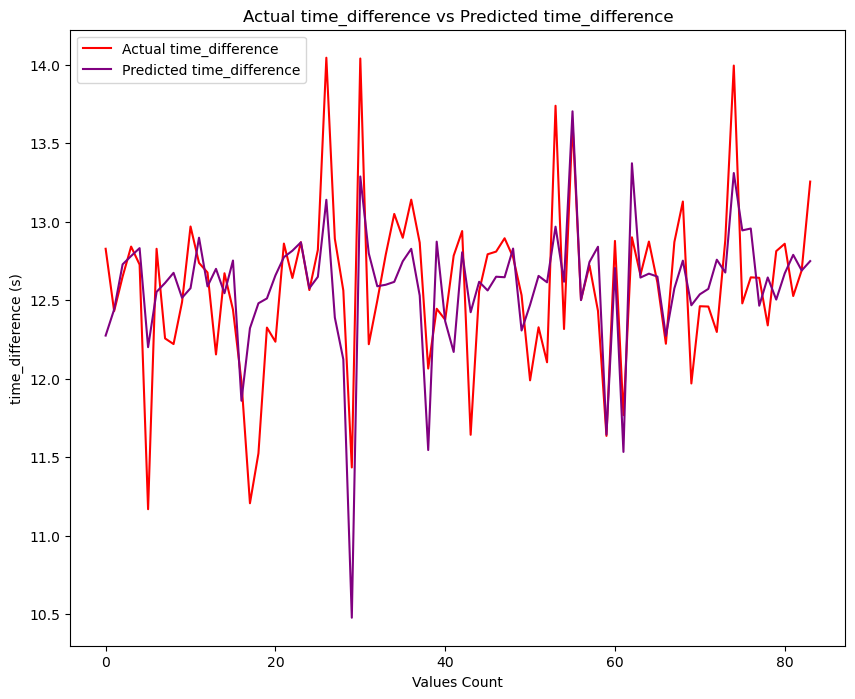

In [11]:
RF(8787590, 600, 'time_difference', parameters2, 'purple')


R squared error (normalized_t_diff, slot range = 600):  0.04502977349905202
Number of training data: 334
Number of testing data: 84


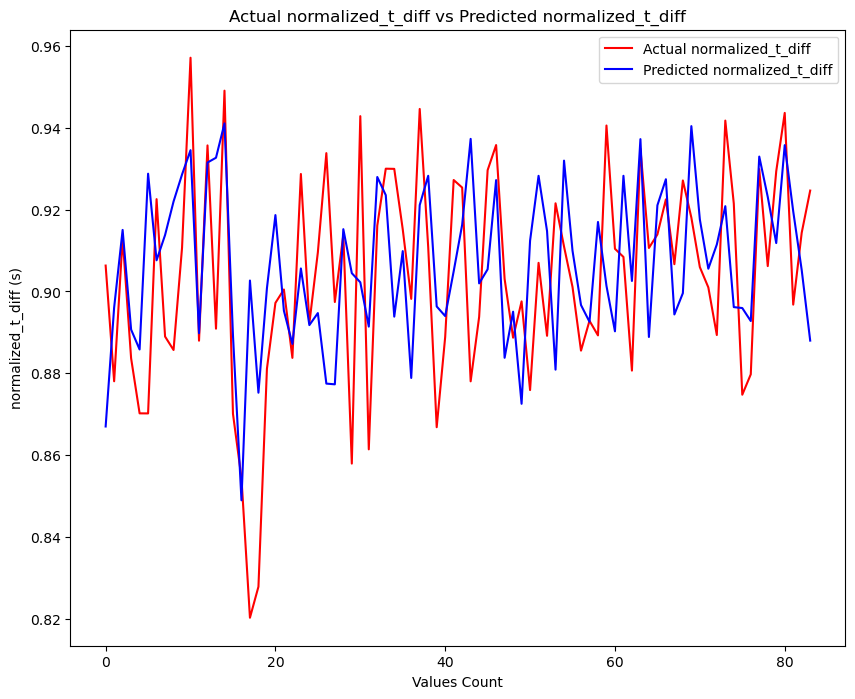

In [12]:
RF(8787590, 600, 'normalised_t_diff', parameters2, 'blue')

# 3. Extract the Best Hyperparameters and Find the Best Slot Range (using GridSearchCV)

In [21]:
def hyperparameter_tuning(X_train, y_train):
    param_grid = {
        'n_estimators': [10, 20, 30, 50, 100, 200],
        'max_depth': [10, 20, 30, 50, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    
    rf = RandomForestRegressor(random_state=42)

    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, 
                               scoring='neg_mean_squared_error', 
                               n_jobs=-1, verbose=0)

    grid_search.fit(X_train, y_train)
    
    print("Best hyperparameters found: ", grid_search.best_params_)
    
    return grid_search.best_estimator_

def RF_turning (slot, S_range, responser, parameters, colour):
    train_range = range(100, S_range, 100) # find the best slide range
    best_train_size = 0
    best_score = -np.inf
    scores = []
    
    for train_size in train_range:
        # Adjust the dataset function as per your data processing requirements
        X_train, X_test, y_train, y_test = dataset(slot, train_size, responser, parameters)
        
        best_rf = hyperparameter_tuning(X_train, y_train)
        y_pred = best_rf.predict(X_test)
        
        score = r2_score(y_test, y_pred)
        scores.append(score)
        print(f"Slot range: {train_size}, R squared error: {score}")
        if score > best_score:
            best_score = score
            best_train_size = train_size

    plt.figure(figsize=(10, 6))
    plt.plot(train_range, scores, color=colour, marker='o')
    plt.title('Model Performance vs. Slot Range (' + responser + ')')
    plt.xlabel('Slot Range')
    plt.ylabel('R Squared Error')
    plt.grid(True)
    plt.ylim(-1, 1)
    plt.savefig(f'graphs/Slot_Range_Performance {responser}.png')
    plt.show()
    print(f"\nBest train size of {responser}: {best_train_size} with R squared error: {best_score}")
    
    return best_train_size, best_rf

Best hyperparameters found:  {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 10}
Train size: 100, R squared error: -0.05429068165572781
Best hyperparameters found:  {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Train size: 200, R squared error: 0.2403030815442031
Best hyperparameters found:  {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Train size: 300, R squared error: 0.1167547269013629
Best hyperparameters found:  {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Train size: 400, R squared error: 0.41808946247856704
Best hyperparameters found:  {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}
Train size: 500, R squared error: 0.4165876429053027
Best hyperparameters found:  {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Train size: 600, R squared error: 0.270

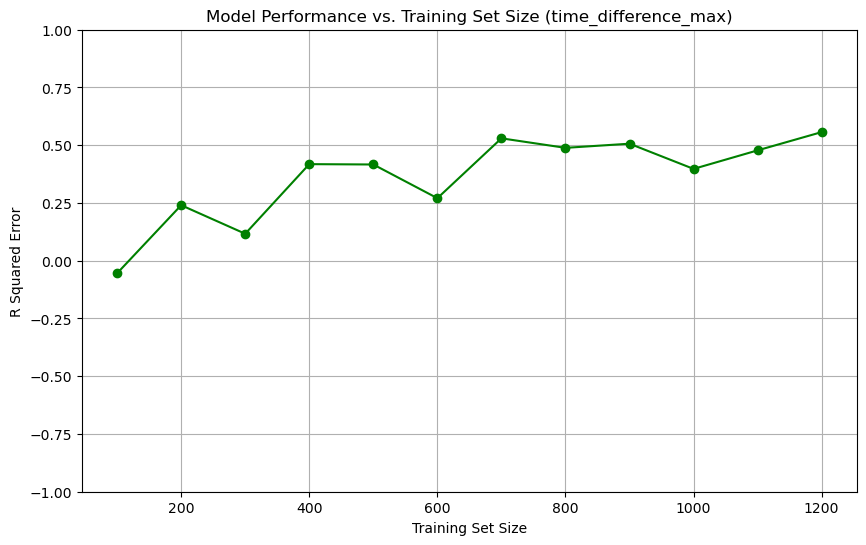


Best train size of time_difference_max: 1200 with R squared error: 0.5568174935998722


In [22]:
best_train_size1, best_rf1 = RF_turning(8787590, 1201, 'time_difference_max', parameters1, 'green')

Best hyperparameters found:  {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 20}
Train size: 100, R squared error: 0.07701049842796182
Best hyperparameters found:  {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 20}
Train size: 200, R squared error: 0.47022941991752265
Best hyperparameters found:  {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Train size: 300, R squared error: 0.1676603363595789
Best hyperparameters found:  {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Train size: 400, R squared error: 0.07597545916305137
Best hyperparameters found:  {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Train size: 500, R squared error: 0.11991615502292852
Best hyperparameters found:  {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Train size: 600, R squared error: 0.409002

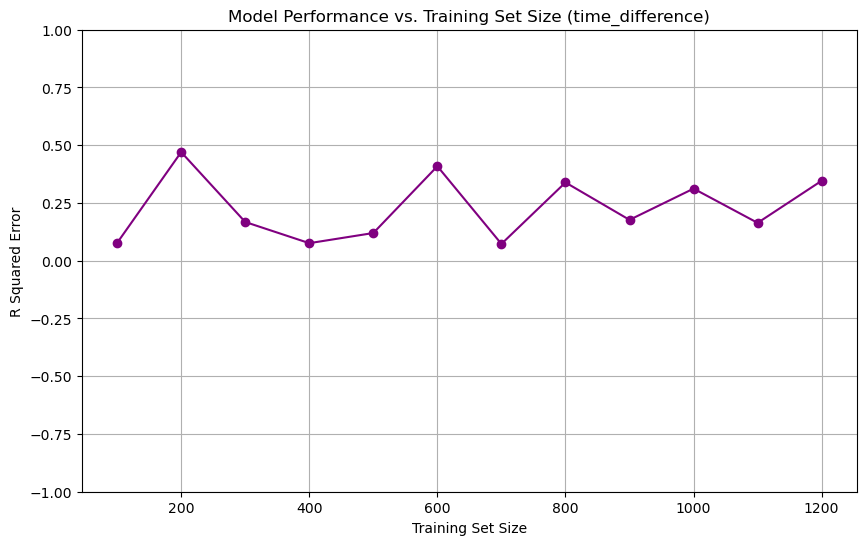


Best train size of time_difference: 200 with R squared error: 0.47022941991752265


In [23]:
best_train_size2, best_rf2 = RF_turning(8787590, 1201, 'time_difference', parameters2, 'purple')

Best hyperparameters found:  {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Train size: 100, R squared error: 0.2682373326850881
Best hyperparameters found:  {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Train size: 200, R squared error: 0.1336686340422788
Best hyperparameters found:  {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
Train size: 300, R squared error: 0.21939293133298987
Best hyperparameters found:  {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Train size: 400, R squared error: 0.19390673715643614
Best hyperparameters found:  {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 30}
Train size: 500, R squared error: 0.19040155000072478
Best hyperparameters found:  {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 30}
Train size: 600, R squared error: -0.24887

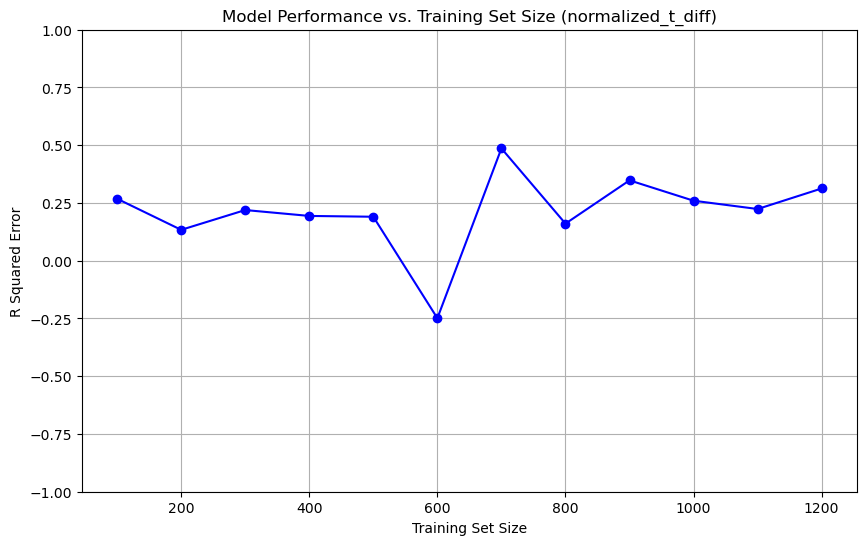


Best train size of normalized_t_diff: 700 with R squared error: 0.4862221426024863


In [24]:
best_train_size3, best_rf3 = RF_turning(8787590, 1201, 'normalised_t_diff', parameters2, 'blue')

# 4. Plot the Optimised Models (using best hyperparameters and slot range)

In [25]:
def plotRF (name, colour):

    plt.figure(figsize=(10, 8))
    plt.plot(list(y_test), color='red', label='Actual ' + name)
    plt.plot(y_pred, color=colour, label='Predicted ' + name)
    plt.title('Actual ' + name + ' vs Predicted ' + name)
    plt.xlabel('Values Count')
    plt.ylabel(name + ' (s)')
    plt.legend()

    plt.savefig(f'graphs/Optimized_{name}_RF_Model.png')
    plt.show()

# Plot optimised predictive model
slot = 8787200

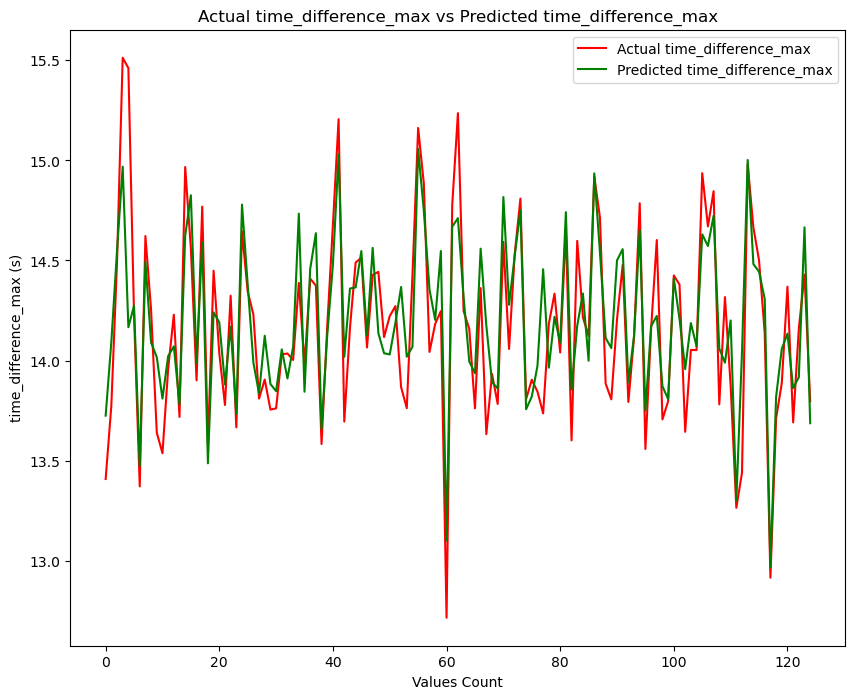

In [26]:
# time_difference_max
X_train, X_test, y_train, y_test = dataset(slot, best_train_size1)
y_pred = best_rf1.predict(X_test)

plotRF('time_difference_max', 'green')

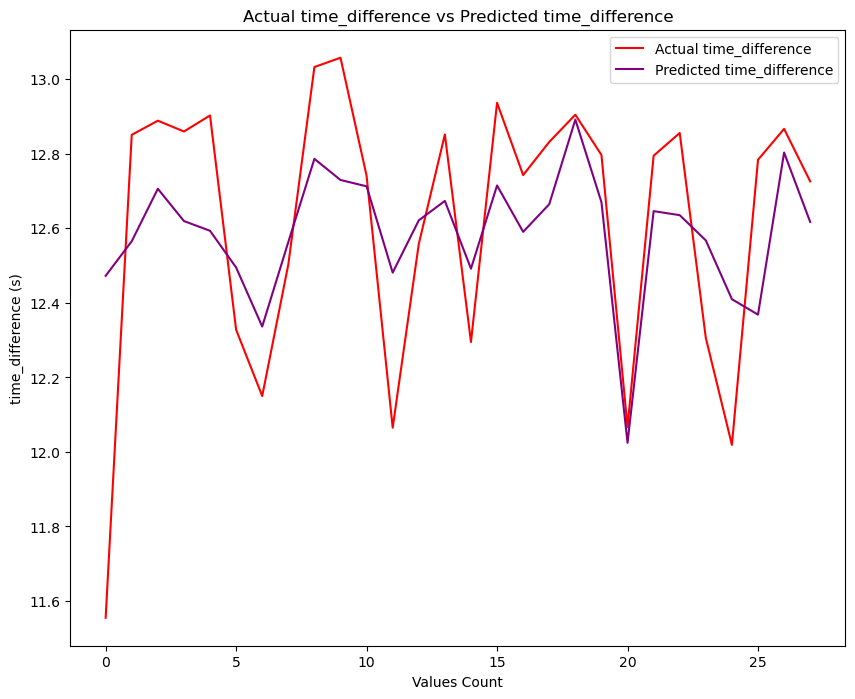

In [27]:
# normalised_t_diff
X_train, X_test, y_train, y_test = dataset(slot, best_train_size2, 'time_difference', parameters2)
y_pred = best_rf2.predict(X_test)

plotRF('time_difference', 'purple')

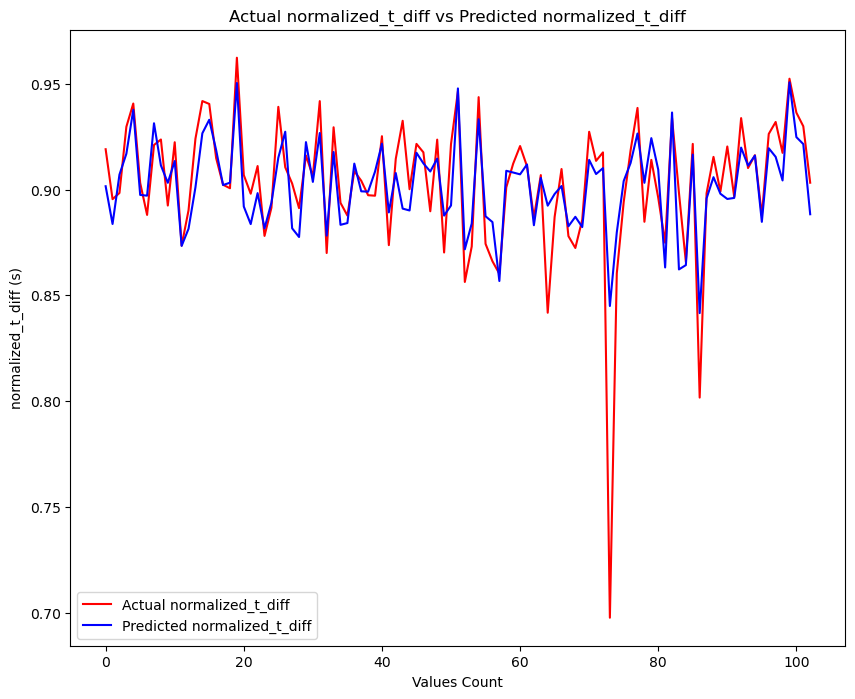

In [28]:
# normalised_t_diff
X_train, X_test, y_train, y_test = dataset(slot, best_train_size3, 'normalised_t_diff', parameters2)
y_pred = best_rf3.predict(X_test)

plotRF('normalised_t_diff', 'blue')